In [1]:
import numpy as np
from matplotlib import pyplot as plt

import loki
from loki.libloki.configs import PulsarSearchConfig
from loki.libloki.ffa import FFAPlan
from loki.libloki.prune import PruningManager
from pyloki.config import ParamLimits
from pyloki.core.taylor import generate_branching_pattern
from pyloki.detection import thresholding
from pyloki.ffa import DynamicProgramming
from pyloki.periodogram import PruningStatsPlotter, ScatteredPeriodogram
from pyloki.prune import prune_dyp_tree
from pyloki.simulation.pulse import PulseSignalConfig

tobs = 2147.483648


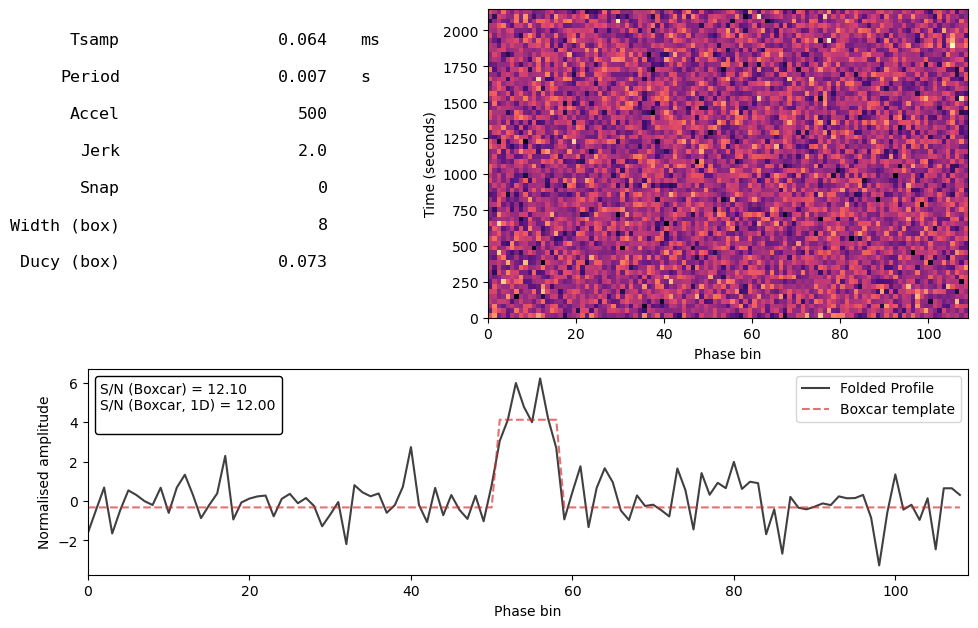

In [2]:
pulsar_period = 0.007
dt = 64e-6
accel = 500
jerk = 2.0
nsamps = 2**25
mod_kwargs = {"acc": accel, "jerk": jerk}
cfg = PulseSignalConfig(period=pulsar_period, dt=dt, nsamps=nsamps, snr=12, ducy=0.1,
                        mod_kwargs=mod_kwargs)
print(f"tobs = {cfg.tobs}")
tim_data = cfg.generate(shape="gaussian")
tim_data.plot_fold(cfg.freq, cfg.fold_bins, mod_kwargs=mod_kwargs)
plt.show()

In [3]:
tol_bins = 1 
fold_bins = 64
p = ParamLimits.from_upper([jerk, accel, cfg.freq], (-2.0 * jerk, jerk * 2.0), cfg.tobs)
print(f"Param limits: {p.limits}")
bseg_brute = cfg.nsamps // 2048
bseg_ffa = cfg.nsamps // 128
search_cfg = PulsarSearchConfig(nsamps=cfg.nsamps, tsamp=cfg.dt, nbins=fold_bins, tol_bins=tol_bins, param_limits=p.limits,
                                bseg_brute=bseg_brute, bseg_ffa=bseg_ffa, prune_poly_order=3, nthreads=4, ducy_max=0.2, wtsp=1.1,
                                use_fft_shifts=True)
plan = FFAPlan(search_cfg)
branching_pattern = plan.generate_branching_pattern()
branching_pattern

Param limits: [(np.float64(-4.0), np.float64(4.0)), (np.float64(-3794.967296), np.float64(4794.967296)), (np.float64(141.50253243280451), np.float64(144.21175328148118))]


array([8.        , 3.        , 2.        , 3.        , 1.        ,
       3.        , 2.        , 3.        , 2.01427098, 1.4893726 ,
       1.        , 1.        , 1.        , 9.        , 2.        ,
       1.        , 1.        , 1.        , 1.        , 3.        ,
       1.        , 1.        , 1.        , 1.        , 3.        ,
       1.        , 1.        , 1.        , 2.01418501, 1.48943617,
       2.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 3.        , 3.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 3.        , 2.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

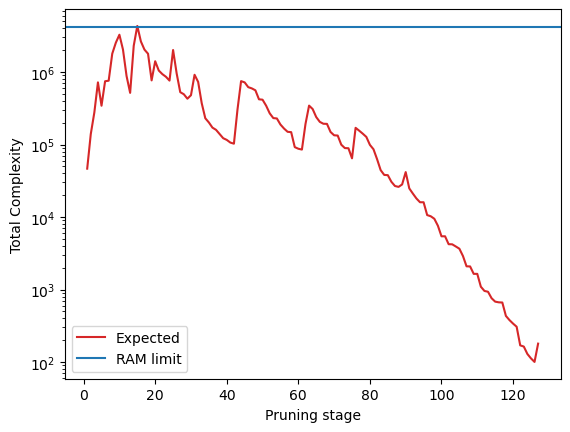

In [4]:
thresholds = np.array([1.6, 1.3, 1.7, 2.2, 2.7, 2.7, 3. , 2.9, 3. , 2.9, 3.2, 3.5, 3.6,
       3.8, 3.5, 3.8, 3.8, 3.7, 4.1, 4.2, 4.2, 4.1, 4. , 4. , 4. , 4.4,
       4.6, 4.4, 4.8, 4.8, 4.6, 4.7, 5. , 5.1, 5. , 5. , 4.9, 4.9, 4.9,
       4.8, 4.8, 4.7, 4.5, 4.8, 4.7, 4.8, 4.7, 4.7, 4.9, 4.7, 4.9, 5. ,
       5. , 4.8, 5. , 5. , 5. , 4.8, 5.2, 5.1, 5. , 5.2, 5.2, 5.2, 5.3,
       5.3, 5.2, 5. , 5.3, 5.3, 5.1, 5.4, 5.4, 5.2, 5.5, 5.4, 5.5, 5.5,
       5.5, 5.6, 5.6, 5.7, 5.8, 5.8, 5.6, 5.8, 5.8, 5.7, 6. , 5.8, 6.1,
       6.1, 6.1, 6.1, 5.8, 6.2, 6.1, 6.1, 6.2, 6.3, 5.9, 6.3, 6.1, 6.2,
       6.2, 6.3, 6.4, 6.2, 6.4, 6. , 6.5, 6.5, 6.4, 6.5, 6.5, 6.4, 6.3,
       6.6, 6.6, 6.6, 6.6, 6.8, 6.7, 6.8, 6.8, 6.8, 6.8])
thresh_state = thresholding.evaluate_scheme(thresholds, branching_pattern, ref_ducy=0.1, nbins=64,
                                            ntrials=1024, snr_final=9.0, ducy_max=0.2, wtsp=1.5)
x = np.arange(1, len(branching_pattern) + 1)
nparam_vol = plan.ncoords[-1]
plt.semilogy(x, np.array(thresh_state.get_info("complexity")) * nparam_vol, label="Expected", c="tab:red")
plt.axhline(2**22, label="RAM limit", c="tab:blue")
plt.xlabel("Pruning stage")
plt.ylabel("Total Complexity")
plt.legend()
plt.show()

In [5]:
prn_manager = PruningManager(search_cfg, thresholds, n_runs=16, max_sugg=2**22, batch_size=1024)
prn_manager.execute(tim_data.ts_e, tim_data.ts_v, outdir="pruning_results/jerk_test/", file_prefix="test_jerk", kind="taylor", show_progress=False)

[2025-08-20 19:25:54.477] [info] PruningManager: Initializing with FFA
[2025-08-20 19:25:54.514] [info] FFACOMPLEX Memory Usage: 0.37 GB (1 buffers) + 0.00 GB (coords)
[2025-08-20 19:25:54.545] [info] FFACOMPLEX::execute started
[2025-08-20 19:25:54.545] [info] FFACOMPLEX::initialize started
[2025-08-20 19:26:07.250] [info] FFACOMPLEX::initialize took 12704 ms
[2025-08-20 19:26:07.283] [info] FFACOMPLEX::execute took 12737 ms
[2025-08-20 19:26:07.289] [info] Starting Pruning for 16 runs, with 4 threads
[2025-08-20 19:26:07.802] [info] Pruning run 008: Memory Usage: 2.63 GB (suggestions) + 0.01 GB (workspace)
[2025-08-20 19:26:07.802] [info] Pruning run 008: initialized
[2025-08-20 19:26:07.815] [info] Pruning run 025: Memory Usage: 2.63 GB (suggestions) + 0.01 GB (workspace)
[2025-08-20 19:26:07.815] [info] Pruning run 017: Memory Usage: 2.63 GB (suggestions) + 0.01 GB (workspace)
[2025-08-20 19:26:07.815] [info] Pruning run 017: initialized
[2025-08-20 19:26:07.815] [info] Pruning run

In [6]:
result_file = "pruning_results/jerk_test/test_jerk_pruning_nstages_128_results.h5"
pgram = ScatteredPeriodogram.load(result_file)
print(f"True params, j: {cfg.mod_kwargs["jerk"]:.3f}, a: {cfg.mod_kwargs["acc"]:.3f}, f: {cfg.freq:.10f}")
print(pgram.get_summary_cands(10, run_id=None))

tions) + 0.01 GB (workspace)
[2025-08-20 19:28:13.059] [info] Pruning run 102: initialized
[2025-08-20 19:28:14.666] [info] Pruning run 085: complete
[2025-08-20 19:28:14.666] [info] Pruning run 085: stats: Score: 8.06, Leaves: 9.50
[2025-08-20 19:28:14.666] [info] Pruning run 085: timer: Total: 40.7s (score: 65% | shift_add: 14% | branch: 9% | batch_add: 5%)
[2025-08-20 19:28:14.888] [info] Pruning run 076: complete
[2025-08-20 19:28:14.888] [info] Pruning run 076: stats: Score: 8.10, Leaves: 9.25
[2025-08-20 19:28:14.888] [info] Pruning run 076: timer: Total: 41.8s (score: 65% | shift_add: 14% | branch: 9% | batch_add: 5%)
[2025-08-20 19:28:15.083] [info] Pruning run 110: Memory Usage: 2.63 GB (suggestions) + 0.01 GB (workspace)
[2025-08-20 19:28:15.084] [info] Pruning run 110: initialized
[2025-08-20 19:28:15.287] [info] Pruning run 119: Memory Usage: 2.63 GB (suggestions) + 0.01 GB (workspace)
[2025-08-20 19:28:15.287] [info] Pruning run 119: initialized
[2025-08-20 19:28:16.669] [

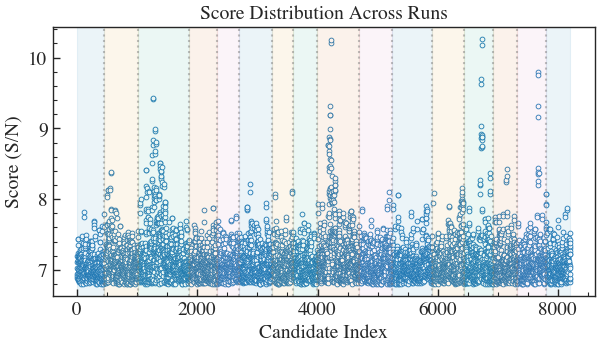

In [7]:
pgram.plot_scores(kind="scatter", run_id=None)
plt.show()

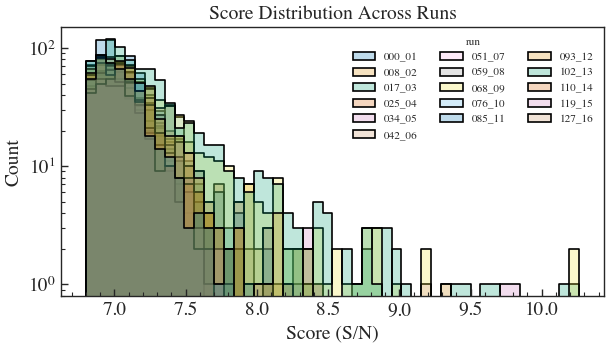

In [8]:
pgram.plot_scores(kind="hist", run_id=None)
plt.show()

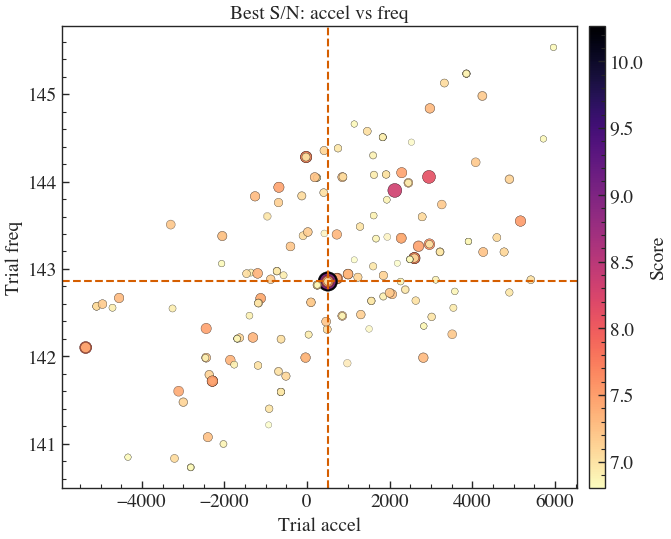

In [11]:
pgram.plot_correlation("accel", "freq", true_values={"accel": cfg.mod_kwargs["acc"], "freq": cfg.freq}, run_id="102_13")
plt.show()

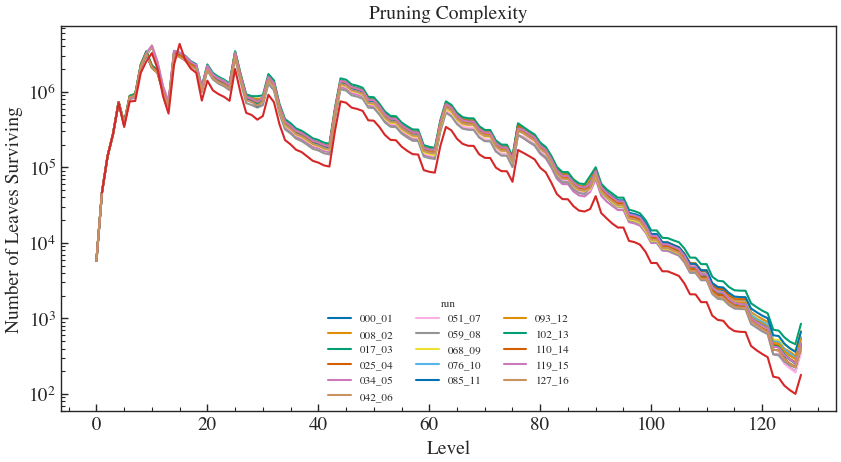

In [12]:
pstats = PruningStatsPlotter.load(result_file)
fig = pstats.plot_level_stats(run_id=None)
x = np.arange(1, len(branching_pattern) + 1)
ax_list = fig.axes
ax_list[0].plot(x, np.array(thresh_state.get_info("complexity")) * nparam_vol, label="Expected", c="tab:red")
plt.show()